In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

In [3]:
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [5]:
train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])

In [6]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
val = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [7]:
class_names = train_dataset.dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Some instance of images

In [8]:
instance = transforms.Compose({
    transforms.ToTensor()
})

In [9]:
for_instance_dataset = datasets.CIFAR10('/data', train=True, download=True, transform=instance)

Files already downloaded and verified


In [10]:
for_instance = DataLoader(for_instance_dataset, batch_size=64, shuffle=True)

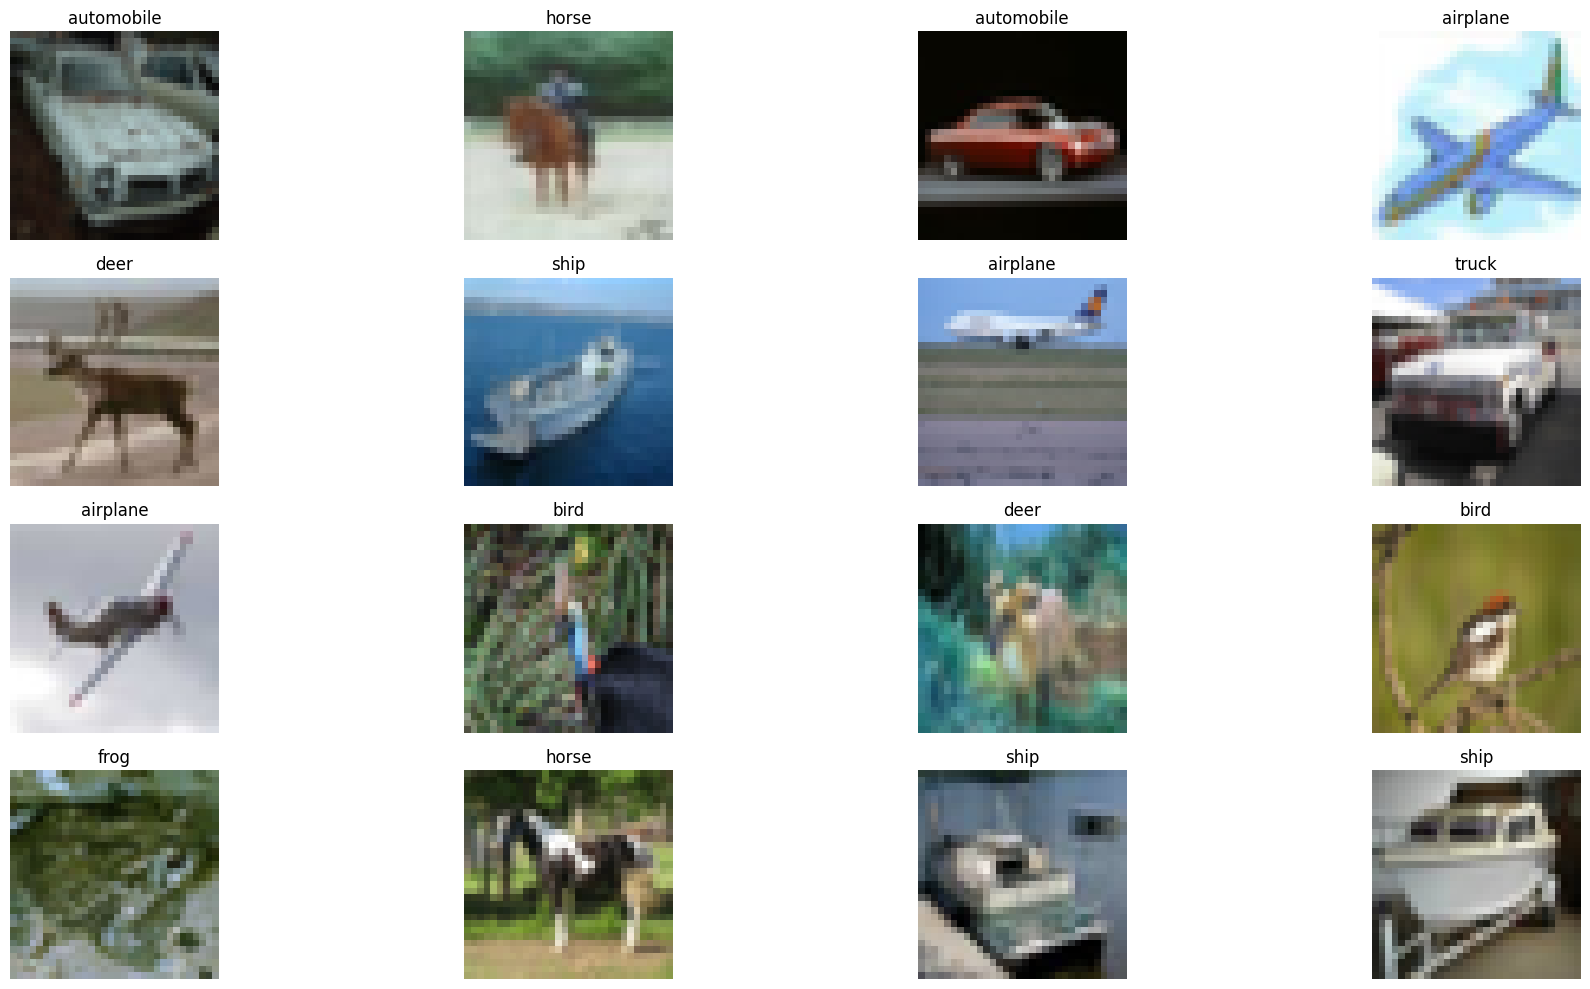

In [11]:
images, labels = next(iter(for_instance))

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model

In [12]:
class CNNModel(nn.Module) :
    def __init__(self):
        super().__init__()
        
        self.CNN_layer = nn.Sequential(
            # 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            # 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3)

        )

        self.FC_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, x) : 
        x = self.CNN_layer(x)
        x = self.FC_layer(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

### Train model

In [14]:
f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

best_f1 = 0
patience = 15
counter = 0


for epoch in range(100) :
    model.train()
    train_loss = 0

    loop_train = tqdm(train, desc=f"Epoch {epoch+1}/{100} [Training]", leave=False)
    for images, labels in loop_train :
        images, labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop_train.set_postfix(loss=loss.item())
    
    model.eval()
    val_loss = 0

    with torch.no_grad() :
        loop_val = tqdm(val, desc=f"Epoch {epoch+1}/{100} [Validation]", leave=False)
        for images, labels in loop_val :
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            loop_val.set_postfix(loss=loss.item())

            f1.update(preds, labels)
            accuracy.update(preds, labels)


    current_f1 = f1.compute().item()
    current_acc = accuracy.compute().item()
    avg_train_loss = train_loss / len(train)
    avg_val_loss = val_loss / len(val)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
        f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    
    f1.reset()
    accuracy.reset()

    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(model.state_dict(), "./Models/CNNModel.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break

Epoch 1 | Train Loss: 1.7458 | Val Loss: 1.7291 | Val F1: 0.3627 | Val Acc: 0.3870
Best model saved at epoch 1 with F1: 0.3627


Epoch 2 | Train Loss: 1.4450 | Val Loss: 1.2537 | Val F1: 0.5307 | Val Acc: 0.5456
Best model saved at epoch 2 with F1: 0.5307


Epoch 3 | Train Loss: 1.2794 | Val Loss: 1.1365 | Val F1: 0.5713 | Val Acc: 0.5822
Best model saved at epoch 3 with F1: 0.5713


Epoch 4 | Train Loss: 1.1739 | Val Loss: 1.0690 | Val F1: 0.6301 | Val Acc: 0.6282
Best model saved at epoch 4 with F1: 0.6301


Epoch 5 | Train Loss: 1.0966 | Val Loss: 1.0084 | Val F1: 0.6098 | Val Acc: 0.6248
No improvement for 1 epochs (patience: 15)


Epoch 6 | Train Loss: 1.0324 | Val Loss: 0.9225 | Val F1: 0.6640 | Val Acc: 0.6767
Best model saved at epoch 6 with F1: 0.6640


Epoch 7 | Train Loss: 0.9846 | Val Loss: 0.8331 | Val F1: 0.7166 | Val Acc: 0.7188
Best model saved at epoch 7 with F1: 0.7166


Epoch 8 | Train Loss: 0.9438 | Val Loss: 0.7835 | Val F1: 0.7149 | Val Acc: 0.7239
No improvement for 1 epochs (patience: 15)


Epoch 9 | Train Loss: 0.9038 | Val Loss: 0.7566 | Val F1: 0.7343 | Val Acc: 0.7380
Best model saved at epoch 9 with F1: 0.7343


Epoch 10 | Train Loss: 0.8830 | Val Loss: 0.7190 | Val F1: 0.7559 | Val Acc: 0.7550
Best model saved at epoch 10 with F1: 0.7559


Epoch 11 | Train Loss: 0.8548 | Val Loss: 0.7224 | Val F1: 0.7537 | Val Acc: 0.7561
No improvement for 1 epochs (patience: 15)


Epoch 12 | Train Loss: 0.8346 | Val Loss: 0.6807 | Val F1: 0.7696 | Val Acc: 0.7708
Best model saved at epoch 12 with F1: 0.7696


Epoch 13 | Train Loss: 0.8239 | Val Loss: 0.6815 | Val F1: 0.7688 | Val Acc: 0.7733
No improvement for 1 epochs (patience: 15)


Epoch 14 | Train Loss: 0.8010 | Val Loss: 0.6386 | Val F1: 0.7844 | Val Acc: 0.7846
Best model saved at epoch 14 with F1: 0.7844


Epoch 15 | Train Loss: 0.7898 | Val Loss: 0.6695 | Val F1: 0.7772 | Val Acc: 0.7781
No improvement for 1 epochs (patience: 15)


Epoch 16 | Train Loss: 0.7795 | Val Loss: 0.6686 | Val F1: 0.7724 | Val Acc: 0.7702
No improvement for 2 epochs (patience: 15)


Epoch 17 | Train Loss: 0.7670 | Val Loss: 0.5850 | Val F1: 0.7960 | Val Acc: 0.7971
Best model saved at epoch 17 with F1: 0.7960


Epoch 18 | Train Loss: 0.7579 | Val Loss: 0.6476 | Val F1: 0.7749 | Val Acc: 0.7758
No improvement for 1 epochs (patience: 15)


Epoch 19 | Train Loss: 0.7544 | Val Loss: 0.6195 | Val F1: 0.7840 | Val Acc: 0.7880
No improvement for 2 epochs (patience: 15)


Epoch 20 | Train Loss: 0.7420 | Val Loss: 0.6741 | Val F1: 0.7800 | Val Acc: 0.7762
No improvement for 3 epochs (patience: 15)


Epoch 21 | Train Loss: 0.7326 | Val Loss: 0.5913 | Val F1: 0.7955 | Val Acc: 0.7998
No improvement for 4 epochs (patience: 15)


Epoch 22 | Train Loss: 0.7259 | Val Loss: 0.5884 | Val F1: 0.8047 | Val Acc: 0.8064
Best model saved at epoch 22 with F1: 0.8047


Epoch 23 | Train Loss: 0.7220 | Val Loss: 0.5708 | Val F1: 0.8036 | Val Acc: 0.8035
No improvement for 1 epochs (patience: 15)


Epoch 24 | Train Loss: 0.7110 | Val Loss: 0.5602 | Val F1: 0.8079 | Val Acc: 0.8092
Best model saved at epoch 24 with F1: 0.8079


Epoch 25 | Train Loss: 0.7092 | Val Loss: 0.5790 | Val F1: 0.8088 | Val Acc: 0.8096
Best model saved at epoch 25 with F1: 0.8088


Epoch 26 | Train Loss: 0.7030 | Val Loss: 0.5431 | Val F1: 0.8181 | Val Acc: 0.8187
Best model saved at epoch 26 with F1: 0.8181


Epoch 27 | Train Loss: 0.6954 | Val Loss: 0.5743 | Val F1: 0.8133 | Val Acc: 0.8107
No improvement for 1 epochs (patience: 15)


Epoch 28 | Train Loss: 0.6908 | Val Loss: 0.5394 | Val F1: 0.8152 | Val Acc: 0.8175
No improvement for 2 epochs (patience: 15)


Epoch 29 | Train Loss: 0.6904 | Val Loss: 0.5695 | Val F1: 0.8031 | Val Acc: 0.8033
No improvement for 3 epochs (patience: 15)


Epoch 30 | Train Loss: 0.6874 | Val Loss: 0.5756 | Val F1: 0.8092 | Val Acc: 0.8099
No improvement for 4 epochs (patience: 15)


Epoch 31 | Train Loss: 0.6841 | Val Loss: 0.5442 | Val F1: 0.8180 | Val Acc: 0.8186
No improvement for 5 epochs (patience: 15)


Epoch 32 | Train Loss: 0.6893 | Val Loss: 0.5843 | Val F1: 0.8036 | Val Acc: 0.8027
No improvement for 6 epochs (patience: 15)


Epoch 33 | Train Loss: 0.6792 | Val Loss: 0.5944 | Val F1: 0.8026 | Val Acc: 0.8013
No improvement for 7 epochs (patience: 15)


Epoch 34 | Train Loss: 0.6744 | Val Loss: 0.5275 | Val F1: 0.8174 | Val Acc: 0.8206
No improvement for 8 epochs (patience: 15)


Epoch 35 | Train Loss: 0.6729 | Val Loss: 0.5216 | Val F1: 0.8280 | Val Acc: 0.8287
Best model saved at epoch 35 with F1: 0.8280


Epoch 36 | Train Loss: 0.6720 | Val Loss: 0.5520 | Val F1: 0.8080 | Val Acc: 0.8079
No improvement for 1 epochs (patience: 15)


Epoch 37 | Train Loss: 0.6683 | Val Loss: 0.5557 | Val F1: 0.8079 | Val Acc: 0.8080
No improvement for 2 epochs (patience: 15)


Epoch 38 | Train Loss: 0.6740 | Val Loss: 0.5285 | Val F1: 0.8197 | Val Acc: 0.8191
No improvement for 3 epochs (patience: 15)


Epoch 39 | Train Loss: 0.6643 | Val Loss: 0.5570 | Val F1: 0.8127 | Val Acc: 0.8116
No improvement for 4 epochs (patience: 15)


Epoch 40 | Train Loss: 0.6696 | Val Loss: 0.5219 | Val F1: 0.8286 | Val Acc: 0.8277
Best model saved at epoch 40 with F1: 0.8286


Epoch 41 | Train Loss: 0.6608 | Val Loss: 0.5414 | Val F1: 0.8123 | Val Acc: 0.8161
No improvement for 1 epochs (patience: 15)


Epoch 42 | Train Loss: 0.6595 | Val Loss: 0.5957 | Val F1: 0.8019 | Val Acc: 0.8001
No improvement for 2 epochs (patience: 15)


Epoch 43 | Train Loss: 0.6545 | Val Loss: 0.4886 | Val F1: 0.8387 | Val Acc: 0.8391
Best model saved at epoch 43 with F1: 0.8387


Epoch 44 | Train Loss: 0.6558 | Val Loss: 0.5286 | Val F1: 0.8153 | Val Acc: 0.8170
No improvement for 1 epochs (patience: 15)


Epoch 45 | Train Loss: 0.6596 | Val Loss: 0.4995 | Val F1: 0.8315 | Val Acc: 0.8311
No improvement for 2 epochs (patience: 15)


Epoch 46 | Train Loss: 0.6607 | Val Loss: 0.5166 | Val F1: 0.8184 | Val Acc: 0.8194
No improvement for 3 epochs (patience: 15)


Epoch 47 | Train Loss: 0.6542 | Val Loss: 0.5854 | Val F1: 0.8034 | Val Acc: 0.8024
No improvement for 4 epochs (patience: 15)


Epoch 48 | Train Loss: 0.6571 | Val Loss: 0.5087 | Val F1: 0.8264 | Val Acc: 0.8275
No improvement for 5 epochs (patience: 15)


Epoch 49 | Train Loss: 0.6453 | Val Loss: 0.4998 | Val F1: 0.8282 | Val Acc: 0.8283
No improvement for 6 epochs (patience: 15)


Epoch 50 | Train Loss: 0.6435 | Val Loss: 0.5201 | Val F1: 0.8151 | Val Acc: 0.8165
No improvement for 7 epochs (patience: 15)


Epoch 51 | Train Loss: 0.6470 | Val Loss: 0.4904 | Val F1: 0.8352 | Val Acc: 0.8370
No improvement for 8 epochs (patience: 15)


Epoch 52 | Train Loss: 0.6537 | Val Loss: 0.5128 | Val F1: 0.8238 | Val Acc: 0.8244
No improvement for 9 epochs (patience: 15)


Epoch 53 | Train Loss: 0.6508 | Val Loss: 0.5031 | Val F1: 0.8319 | Val Acc: 0.8320
No improvement for 10 epochs (patience: 15)


Epoch 54 | Train Loss: 0.6442 | Val Loss: 0.4673 | Val F1: 0.8368 | Val Acc: 0.8380
No improvement for 11 epochs (patience: 15)


Epoch 55 | Train Loss: 0.6548 | Val Loss: 0.5119 | Val F1: 0.8265 | Val Acc: 0.8257
No improvement for 12 epochs (patience: 15)


Epoch 56 | Train Loss: 0.6476 | Val Loss: 0.4914 | Val F1: 0.8326 | Val Acc: 0.8340
No improvement for 13 epochs (patience: 15)


Epoch 57 | Train Loss: 0.6431 | Val Loss: 0.5365 | Val F1: 0.8062 | Val Acc: 0.8112
No improvement for 14 epochs (patience: 15)


Epoch 58 | Train Loss: 0.6439 | Val Loss: 0.5117 | Val F1: 0.8280 | Val Acc: 0.8287
No improvement for 15 epochs (patience: 15)
Early stopping at epoch 58. Best F1: 0.8387


### Load best Model

In [15]:
model.load_state_dict(torch.load("./Models/CNNModel.pth"))

C:\Users\Legion\AppData\Local\Temp\ipykernel_19692\1629943097.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./Models/CNNModel.pth"))


<All keys matched successfully>

### Test verification

In [16]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75},
                xticklabels=class_names,
                yticklabels=class_names
    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

Test Accuracy:0.8371 | Test F1:0.8373


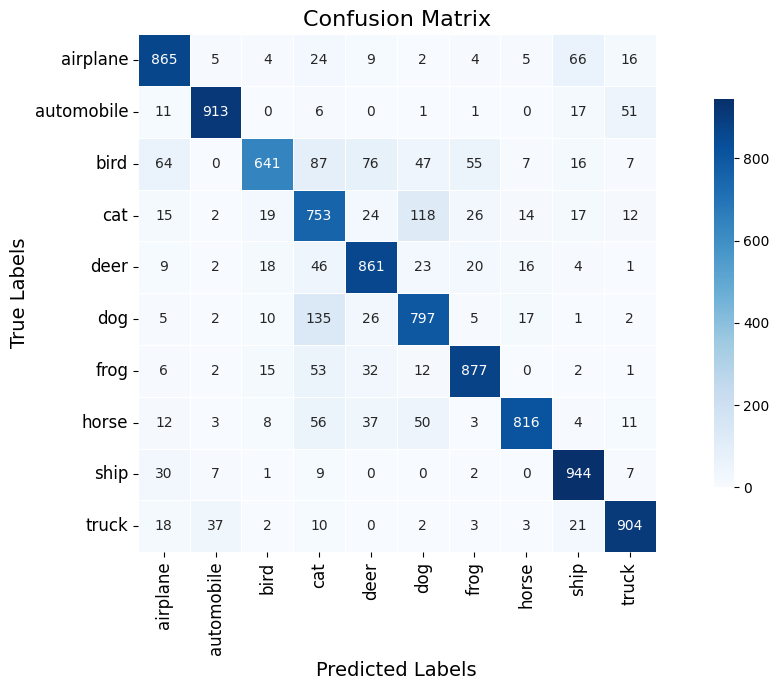

In [17]:
with torch.no_grad() :
    f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
    accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

    with torch.no_grad() :
        for images, labels in test :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            f1_test.update(output, labels)
            accuracy_test.update(output, labels)
            CF.update(output, labels)

    print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
    creat_heatmap(CF)

- Still can be improved

### New Model structure

In [18]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 128 -> 2256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout2d(0.4)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Improvedmodel = ImprovedCNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(Improvedmodel.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [20]:
f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

best_f1 = 0
patience = 15
counter = 0


for epoch in range(100) :
    Improvedmodel.train()
    train_loss = 0

    loop_train = tqdm(train, desc=f"Epoch {epoch+1}/{100} [Training]", leave=False)
    for images, labels in loop_train :
        images, labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = Improvedmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop_train.set_postfix(loss=loss.item())
    
    Improvedmodel.eval()
    val_loss = 0

    with torch.no_grad() :
        loop_val = tqdm(val, desc=f"Epoch {epoch+1}/{100} [Validation]", leave=False)
        for images, labels in loop_val :
            images, labels = images.to(device), labels.to(device)
            outputs = Improvedmodel(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            loop_val.set_postfix(loss=loss.item())

            f1.update(preds, labels)
            accuracy.update(preds, labels)


    current_f1 = f1.compute().item()
    current_acc = accuracy.compute().item()
    avg_train_loss = train_loss / len(train)
    avg_val_loss = val_loss / len(val)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
        f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    
    f1.reset()
    accuracy.reset()

    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(Improvedmodel.state_dict(), "./Models/ImporovedCNNModel.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler.step()

Epoch 1 | Train Loss: 1.8903 | Val Loss: 1.6469 | Val F1: 0.2801 | Val Acc: 0.3477
Best model saved at epoch 1 with F1: 0.2801


Epoch 2 | Train Loss: 1.5533 | Val Loss: 1.5789 | Val F1: 0.4210 | Val Acc: 0.4507
Best model saved at epoch 2 with F1: 0.4210


Epoch 3 | Train Loss: 1.3051 | Val Loss: 1.2134 | Val F1: 0.5649 | Val Acc: 0.5779
Best model saved at epoch 3 with F1: 0.5649


Epoch 4 | Train Loss: 1.1161 | Val Loss: 1.0291 | Val F1: 0.6513 | Val Acc: 0.6555
Best model saved at epoch 4 with F1: 0.6513


Epoch 5 | Train Loss: 0.9774 | Val Loss: 0.8691 | Val F1: 0.7007 | Val Acc: 0.7017
Best model saved at epoch 5 with F1: 0.7007


Epoch 6 | Train Loss: 0.8826 | Val Loss: 0.7142 | Val F1: 0.7581 | Val Acc: 0.7582
Best model saved at epoch 6 with F1: 0.7581


Epoch 7 | Train Loss: 0.8049 | Val Loss: 0.6485 | Val F1: 0.7864 | Val Acc: 0.7870
Best model saved at epoch 7 with F1: 0.7864


Epoch 8 | Train Loss: 0.7573 | Val Loss: 0.6463 | Val F1: 0.7867 | Val Acc: 0.7859
Best model saved at epoch 8 with F1: 0.7867


Epoch 9 | Train Loss: 0.7130 | Val Loss: 0.6175 | Val F1: 0.7956 | Val Acc: 0.7941
Best model saved at epoch 9 with F1: 0.7956


Epoch 10 | Train Loss: 0.6793 | Val Loss: 0.6338 | Val F1: 0.7896 | Val Acc: 0.7876
No improvement for 1 epochs (patience: 15)


Epoch 11 | Train Loss: 0.6492 | Val Loss: 0.6076 | Val F1: 0.7962 | Val Acc: 0.7966
Best model saved at epoch 11 with F1: 0.7962


Epoch 12 | Train Loss: 0.6146 | Val Loss: 0.5241 | Val F1: 0.8261 | Val Acc: 0.8278
Best model saved at epoch 12 with F1: 0.8261


Epoch 13 | Train Loss: 0.5980 | Val Loss: 0.6181 | Val F1: 0.8035 | Val Acc: 0.8066
No improvement for 1 epochs (patience: 15)


Epoch 14 | Train Loss: 0.5904 | Val Loss: 0.5823 | Val F1: 0.8029 | Val Acc: 0.8046
No improvement for 2 epochs (patience: 15)


Epoch 15 | Train Loss: 0.5710 | Val Loss: 0.5141 | Val F1: 0.8297 | Val Acc: 0.8306
Best model saved at epoch 15 with F1: 0.8297


Epoch 16 | Train Loss: 0.5671 | Val Loss: 0.7477 | Val F1: 0.7544 | Val Acc: 0.7532
No improvement for 1 epochs (patience: 15)


Epoch 17 | Train Loss: 0.5317 | Val Loss: 0.5659 | Val F1: 0.8053 | Val Acc: 0.8053
No improvement for 2 epochs (patience: 15)


Epoch 18 | Train Loss: 0.5302 | Val Loss: 0.5569 | Val F1: 0.8171 | Val Acc: 0.8147
No improvement for 3 epochs (patience: 15)


Epoch 19 | Train Loss: 0.5188 | Val Loss: 0.4811 | Val F1: 0.8375 | Val Acc: 0.8389
Best model saved at epoch 19 with F1: 0.8375


Epoch 20 | Train Loss: 0.5071 | Val Loss: 0.5017 | Val F1: 0.8287 | Val Acc: 0.8308
No improvement for 1 epochs (patience: 15)


Epoch 21 | Train Loss: 0.3910 | Val Loss: 0.4209 | Val F1: 0.8634 | Val Acc: 0.8633
Best model saved at epoch 21 with F1: 0.8634


Epoch 22 | Train Loss: 0.3701 | Val Loss: 0.4174 | Val F1: 0.8628 | Val Acc: 0.8629
No improvement for 1 epochs (patience: 15)


Epoch 23 | Train Loss: 0.3602 | Val Loss: 0.4154 | Val F1: 0.8661 | Val Acc: 0.8660
Best model saved at epoch 23 with F1: 0.8661


Epoch 24 | Train Loss: 0.3395 | Val Loss: 0.4759 | Val F1: 0.8498 | Val Acc: 0.8490
No improvement for 1 epochs (patience: 15)


Epoch 25 | Train Loss: 0.3349 | Val Loss: 0.4111 | Val F1: 0.8714 | Val Acc: 0.8726
Best model saved at epoch 25 with F1: 0.8714


Epoch 26 | Train Loss: 0.3350 | Val Loss: 0.4189 | Val F1: 0.8607 | Val Acc: 0.8626
No improvement for 1 epochs (patience: 15)


Epoch 27 | Train Loss: 0.3247 | Val Loss: 0.4117 | Val F1: 0.8690 | Val Acc: 0.8696
No improvement for 2 epochs (patience: 15)


Epoch 28 | Train Loss: 0.3140 | Val Loss: 0.4476 | Val F1: 0.8574 | Val Acc: 0.8588
No improvement for 3 epochs (patience: 15)


Epoch 29 | Train Loss: 0.3060 | Val Loss: 0.4085 | Val F1: 0.8733 | Val Acc: 0.8743
Best model saved at epoch 29 with F1: 0.8733


Epoch 30 | Train Loss: 0.3079 | Val Loss: 0.4069 | Val F1: 0.8703 | Val Acc: 0.8694
No improvement for 1 epochs (patience: 15)


Epoch 31 | Train Loss: 0.2990 | Val Loss: 0.4712 | Val F1: 0.8479 | Val Acc: 0.8504
No improvement for 2 epochs (patience: 15)


Epoch 32 | Train Loss: 0.2973 | Val Loss: 0.4306 | Val F1: 0.8664 | Val Acc: 0.8667
No improvement for 3 epochs (patience: 15)


Epoch 33 | Train Loss: 0.2927 | Val Loss: 0.4011 | Val F1: 0.8715 | Val Acc: 0.8711
No improvement for 4 epochs (patience: 15)


Epoch 34 | Train Loss: 0.2889 | Val Loss: 0.4152 | Val F1: 0.8623 | Val Acc: 0.8634
No improvement for 5 epochs (patience: 15)


Epoch 35 | Train Loss: 0.2928 | Val Loss: 0.4060 | Val F1: 0.8733 | Val Acc: 0.8715
Best model saved at epoch 35 with F1: 0.8733


Epoch 36 | Train Loss: 0.2847 | Val Loss: 0.4005 | Val F1: 0.8681 | Val Acc: 0.8673
No improvement for 1 epochs (patience: 15)


Epoch 37 | Train Loss: 0.2836 | Val Loss: 0.3981 | Val F1: 0.8695 | Val Acc: 0.8701
No improvement for 2 epochs (patience: 15)


Epoch 38 | Train Loss: 0.2840 | Val Loss: 0.3873 | Val F1: 0.8783 | Val Acc: 0.8773
Best model saved at epoch 38 with F1: 0.8783


Epoch 39 | Train Loss: 0.2807 | Val Loss: 0.3764 | Val F1: 0.8804 | Val Acc: 0.8809
Best model saved at epoch 39 with F1: 0.8804


Epoch 40 | Train Loss: 0.2856 | Val Loss: 0.4045 | Val F1: 0.8731 | Val Acc: 0.8727
No improvement for 1 epochs (patience: 15)


Epoch 41 | Train Loss: 0.2068 | Val Loss: 0.3665 | Val F1: 0.8924 | Val Acc: 0.8934
Best model saved at epoch 41 with F1: 0.8924


Epoch 42 | Train Loss: 0.1932 | Val Loss: 0.3549 | Val F1: 0.8944 | Val Acc: 0.8943
Best model saved at epoch 42 with F1: 0.8944


Epoch 43 | Train Loss: 0.1839 | Val Loss: 0.3725 | Val F1: 0.8878 | Val Acc: 0.8870
No improvement for 1 epochs (patience: 15)


Epoch 44 | Train Loss: 0.1764 | Val Loss: 0.3914 | Val F1: 0.8877 | Val Acc: 0.8887
No improvement for 2 epochs (patience: 15)


Epoch 45 | Train Loss: 0.1771 | Val Loss: 0.3618 | Val F1: 0.8942 | Val Acc: 0.8941
No improvement for 3 epochs (patience: 15)


Epoch 46 | Train Loss: 0.1758 | Val Loss: 0.3828 | Val F1: 0.8870 | Val Acc: 0.8870
No improvement for 4 epochs (patience: 15)


Epoch 47 | Train Loss: 0.1671 | Val Loss: 0.3710 | Val F1: 0.8953 | Val Acc: 0.8953
Best model saved at epoch 47 with F1: 0.8953


Epoch 48 | Train Loss: 0.1708 | Val Loss: 0.3675 | Val F1: 0.8883 | Val Acc: 0.8889
No improvement for 1 epochs (patience: 15)


Epoch 49 | Train Loss: 0.1656 | Val Loss: 0.3800 | Val F1: 0.8867 | Val Acc: 0.8878
No improvement for 2 epochs (patience: 15)


Epoch 50 | Train Loss: 0.1592 | Val Loss: 0.4064 | Val F1: 0.8880 | Val Acc: 0.8868
No improvement for 3 epochs (patience: 15)


Epoch 51 | Train Loss: 0.1583 | Val Loss: 0.4068 | Val F1: 0.8834 | Val Acc: 0.8841
No improvement for 4 epochs (patience: 15)


Epoch 52 | Train Loss: 0.1627 | Val Loss: 0.3728 | Val F1: 0.8927 | Val Acc: 0.8930
No improvement for 5 epochs (patience: 15)


Epoch 53 | Train Loss: 0.1494 | Val Loss: 0.4023 | Val F1: 0.8887 | Val Acc: 0.8894
No improvement for 6 epochs (patience: 15)


Epoch 54 | Train Loss: 0.1526 | Val Loss: 0.3732 | Val F1: 0.8905 | Val Acc: 0.8915
No improvement for 7 epochs (patience: 15)


Epoch 55 | Train Loss: 0.1530 | Val Loss: 0.4107 | Val F1: 0.8866 | Val Acc: 0.8867
No improvement for 8 epochs (patience: 15)


Epoch 56 | Train Loss: 0.1580 | Val Loss: 0.4009 | Val F1: 0.8924 | Val Acc: 0.8916
No improvement for 9 epochs (patience: 15)


Epoch 57 | Train Loss: 0.1515 | Val Loss: 0.3962 | Val F1: 0.8912 | Val Acc: 0.8913
No improvement for 10 epochs (patience: 15)


Epoch 58 | Train Loss: 0.1475 | Val Loss: 0.3819 | Val F1: 0.8902 | Val Acc: 0.8898
No improvement for 11 epochs (patience: 15)


Epoch 59 | Train Loss: 0.1452 | Val Loss: 0.3984 | Val F1: 0.8903 | Val Acc: 0.8901
No improvement for 12 epochs (patience: 15)


Epoch 60 | Train Loss: 0.1509 | Val Loss: 0.3990 | Val F1: 0.8876 | Val Acc: 0.8871
No improvement for 13 epochs (patience: 15)


Epoch 61 | Train Loss: 0.1089 | Val Loss: 0.3699 | Val F1: 0.9008 | Val Acc: 0.9013
Best model saved at epoch 61 with F1: 0.9008


Epoch 62 | Train Loss: 0.0959 | Val Loss: 0.3782 | Val F1: 0.8994 | Val Acc: 0.8991
No improvement for 1 epochs (patience: 15)


Epoch 63 | Train Loss: 0.0929 | Val Loss: 0.3831 | Val F1: 0.9026 | Val Acc: 0.9027
Best model saved at epoch 63 with F1: 0.9026


Epoch 64 | Train Loss: 0.0939 | Val Loss: 0.3695 | Val F1: 0.9004 | Val Acc: 0.9009
No improvement for 1 epochs (patience: 15)


Epoch 65 | Train Loss: 0.0944 | Val Loss: 0.3663 | Val F1: 0.9043 | Val Acc: 0.9042
Best model saved at epoch 65 with F1: 0.9043


Epoch 66 | Train Loss: 0.0914 | Val Loss: 0.3821 | Val F1: 0.9025 | Val Acc: 0.9027
No improvement for 1 epochs (patience: 15)


Epoch 67 | Train Loss: 0.0824 | Val Loss: 0.4267 | Val F1: 0.8974 | Val Acc: 0.8967
No improvement for 2 epochs (patience: 15)


Epoch 68 | Train Loss: 0.0886 | Val Loss: 0.3800 | Val F1: 0.9014 | Val Acc: 0.9019
No improvement for 3 epochs (patience: 15)


Epoch 69 | Train Loss: 0.0838 | Val Loss: 0.3963 | Val F1: 0.8980 | Val Acc: 0.8985
No improvement for 4 epochs (patience: 15)


Epoch 70 | Train Loss: 0.0860 | Val Loss: 0.3956 | Val F1: 0.9011 | Val Acc: 0.9016
No improvement for 5 epochs (patience: 15)


Epoch 71 | Train Loss: 0.0845 | Val Loss: 0.4443 | Val F1: 0.8947 | Val Acc: 0.8955
No improvement for 6 epochs (patience: 15)


Epoch 72 | Train Loss: 0.0791 | Val Loss: 0.4145 | Val F1: 0.8987 | Val Acc: 0.8982
No improvement for 7 epochs (patience: 15)


Epoch 73 | Train Loss: 0.0791 | Val Loss: 0.3968 | Val F1: 0.8984 | Val Acc: 0.8985
No improvement for 8 epochs (patience: 15)


Epoch 74 | Train Loss: 0.0814 | Val Loss: 0.3945 | Val F1: 0.8968 | Val Acc: 0.8970
No improvement for 9 epochs (patience: 15)


Epoch 75 | Train Loss: 0.0772 | Val Loss: 0.4175 | Val F1: 0.9005 | Val Acc: 0.9002
No improvement for 10 epochs (patience: 15)


Epoch 76 | Train Loss: 0.0773 | Val Loss: 0.4679 | Val F1: 0.8929 | Val Acc: 0.8930
No improvement for 11 epochs (patience: 15)


Epoch 77 | Train Loss: 0.0779 | Val Loss: 0.4529 | Val F1: 0.8897 | Val Acc: 0.8897
No improvement for 12 epochs (patience: 15)


Epoch 78 | Train Loss: 0.0761 | Val Loss: 0.4516 | Val F1: 0.8984 | Val Acc: 0.8992
No improvement for 13 epochs (patience: 15)


Epoch 79 | Train Loss: 0.0775 | Val Loss: 0.4177 | Val F1: 0.8967 | Val Acc: 0.8971
No improvement for 14 epochs (patience: 15)


Epoch 80 | Train Loss: 0.0772 | Val Loss: 0.4301 | Val F1: 0.8969 | Val Acc: 0.8968
No improvement for 15 epochs (patience: 15)
Early stopping at epoch 80. Best F1: 0.9043


### Load model

In [21]:
Improvedmodel.load_state_dict(torch.load("./Models/ImporovedCNNModel.pth"))

C:\Users\Legion\AppData\Local\Temp\ipykernel_19692\2589168535.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Improvedmodel.load_state_dict(torch.load("./Models/Imporove

<All keys matched successfully>

### New model test validation

Test Accuracy:0.9073 | Test F1:0.9071


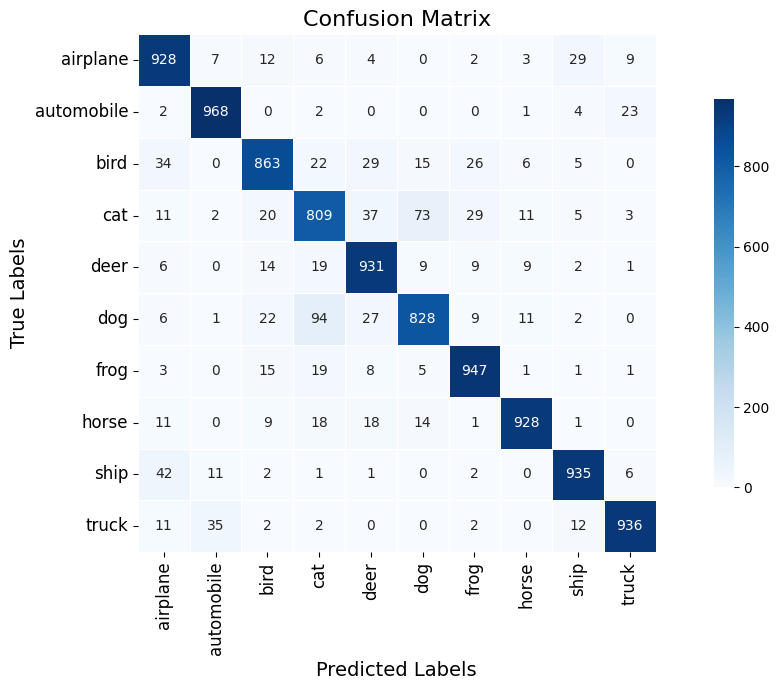

In [22]:
f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

with torch.no_grad() :
    for images, labels in test :
        images, labels = images.to(device), labels.to(device)
        output = Improvedmodel(images)
        f1_test.update(output, labels)
        accuracy_test.update(output, labels)
        CF.update(output, labels)

print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
creat_heatmap(CF)

- Get significantly better

# Training Summary

## Epoch Summary

- Total Epochs: 80  
- Initial F1 Score: **0.2801** (Epoch 1)  
- Fast improvement in the first 10 epochs, reaching **F1 ≈ 0.79**  
- Gradual improvements between Epochs 11–40  
- Significant jumps:
  - Epoch 25: F1 = `0.8714`
  - Epoch 39: F1 = `0.8804`
  - Epoch 42: F1 = `0.8944`
  - Epoch 65: **Best F1 = 0.9043**
- Early stopping triggered at epoch 80 (no improvement for 15 epochs)

---

## Key Epoch Results

| Epoch | Train Loss | Val Loss | Val F1  | Val Acc | Note                  |
|-------|------------|----------|---------|---------|-----------------------|
| 1     | 1.8903     | 1.6469   | 0.2801  | 0.3477  | Best model saved      |
| 2     | 1.5533     | 1.5789   | 0.4210  | 0.4507  | Best model saved      |
| 5     | 0.9774     | 0.8691   | 0.7007  | 0.7017  | Best model saved      |
| 9     | 0.7130     | 0.6175   | 0.7956  | 0.7941  | Best model saved      |
| 12    | 0.6146     | 0.5241   | 0.8261  | 0.8278  | Best model saved      |
| 19    | 0.5188     | 0.4811   | 0.8375  | 0.8389  | Best model saved      |
| 25    | 0.3349     | 0.4111   | 0.8714  | 0.8726  | Best model saved      |
| 29    | 0.3060     | 0.4085   | 0.8733  | 0.8743  | Best model saved      |
| 39    | 0.2807     | 0.3764   | 0.8804  | 0.8809  | Best model saved      |
| 42    | 0.1932     | 0.3549   | 0.8944  | 0.8943  | Best model saved      |
| 47    | 0.1671     | 0.3710   | 0.8953  | 0.8953  | Best model saved      |
| 61    | 0.1089     | 0.3699   | 0.9008  | 0.9013  | Best model saved      |
| 63    | 0.0929     | 0.3831   | 0.9026  | 0.9027  | Best model saved      |
| 65    | 0.0944     | 0.3663   | 0.9043  | 0.9042  | **Best F1 Overall** |
| 80    | 0.0772     | 0.4301   | 0.8969  | 0.8968  | Early stopping      |

---

## Final Test Results

- **Test Accuracy:** `0.9073`  
- **Test F1 Score:** `0.9071`
